<a href="https://colab.research.google.com/github/Sushmitha-Katti/EVA-4/blob/master/Session5/Code2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Code2**
**Target**
1.  Added 1 more convolution layer and Gap Layer
2. Changed the number of kernels in some conv layers
3. Increased the capacity

**Results**
1.  Parameters - 9634
2.  Best training accuracy- 98.67
3.  Best test accuracy - 99.4


**Analysis**
1. Target is reached, but only once.
2. Model is still under-fitting












# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


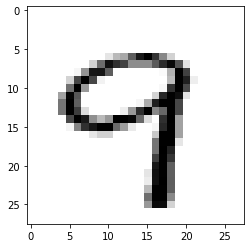

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

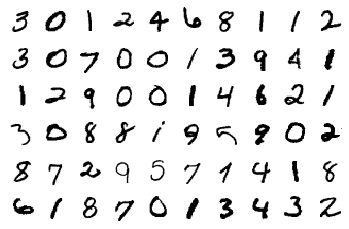

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(                      
            
        nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),#Op_size = 26, RF = 3
        nn.ReLU(),
        nn.BatchNorm2d(10),
        nn.Dropout2d(0.1),

        nn.Conv2d(in_channels=10, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),#Op_size = 24, RF = 5
        nn.ReLU(),
        nn.BatchNorm2d(12),
        nn.Dropout2d(0.1),

        nn.MaxPool2d(kernel_size=(2,2)), #Op_size = 12, RF = 6

        nn.Conv2d(in_channels=12, out_channels=14, kernel_size=(3, 3), padding=0, bias=False), #Op_size = 10, RF = 10   
        nn.ReLU(),
        nn.BatchNorm2d(14),
        nn.Dropout2d(0.1),

        nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), #Op_size = 8, RF = 14
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout2d(0.1),

        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),#Op_size = 6, RF = 18 
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout(0.1),

        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),#Op_size = 6, RF = 22 
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout(0.1),

        nn.AvgPool2d(kernel_size=6),

        # nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=False ), #Op_size = 4, RF = 22
        # nn.ReLU(),
        # nn.BatchNorm2d(16),
        # nn.Dropout2d(0.15),

        # nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), #Op_size = 2, RF = 26
        # nn.ReLU(),
        # nn.BatchNorm2d(16),
        # nn.Dropout2d(0.15),

        nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)#Op_size = 1, RF = 28
        ) 

    def forward(self, x):
        x = self.conv1(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [31]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
         Dropout2d-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 12, 24, 24]           1,080
              ReLU-6           [-1, 12, 24, 24]               0
       BatchNorm2d-7           [-1, 12, 24, 24]              24
         Dropout2d-8           [-1, 12, 24, 24]               0
         MaxPool2d-9           [-1, 12, 12, 12]               0
           Conv2d-10           [-1, 14, 10, 10]           1,512
             ReLU-11           [-1, 14, 10, 10]               0
      BatchNorm2d-12           [-1, 14, 10, 10]              28
        Dropout2d-13           [-1, 14, 10, 10]               0
           Conv2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [33]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.1748407930135727 Batch_id=468 Accuracy=83.83: 100%|██████████| 469/469 [00:18<00:00, 25.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0816, Accuracy: 9778/10000 (97.78%)

EPOCH: 1


Loss=0.12438967823982239 Batch_id=468 Accuracy=96.32: 100%|██████████| 469/469 [00:18<00:00, 25.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0463, Accuracy: 9869/10000 (98.69%)

EPOCH: 2


Loss=0.08452247828245163 Batch_id=468 Accuracy=97.30: 100%|██████████| 469/469 [00:18<00:00, 32.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0360, Accuracy: 9879/10000 (98.79%)

EPOCH: 3


Loss=0.07974281907081604 Batch_id=468 Accuracy=97.66: 100%|██████████| 469/469 [00:18<00:00, 25.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0328, Accuracy: 9899/10000 (98.99%)

EPOCH: 4


Loss=0.06238313019275665 Batch_id=468 Accuracy=97.84: 100%|██████████| 469/469 [00:17<00:00, 26.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 9906/10000 (99.06%)

EPOCH: 5


Loss=0.06117981672286987 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:18<00:00, 25.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9914/10000 (99.14%)

EPOCH: 6


Loss=0.049836382269859314 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:18<00:00, 25.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Accuracy: 9911/10000 (99.11%)

EPOCH: 7


Loss=0.05768169090151787 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:18<00:00, 25.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9925/10000 (99.25%)

EPOCH: 8


Loss=0.05683233216404915 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:18<00:00, 31.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9939/10000 (99.39%)

EPOCH: 9


Loss=0.01947050355374813 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:18<00:00, 25.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9929/10000 (99.29%)

EPOCH: 10


Loss=0.038135141134262085 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:18<00:00, 25.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9940/10000 (99.40%)

EPOCH: 11


Loss=0.07324082404375076 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:18<00:00, 33.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9936/10000 (99.36%)

EPOCH: 12


Loss=0.07248738408088684 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:18<00:00, 25.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9931/10000 (99.31%)

EPOCH: 13


Loss=0.047720108181238174 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:18<00:00, 25.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9935/10000 (99.35%)

EPOCH: 14


Loss=0.07684624195098877 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:18<00:00, 25.23it/s]



Test set: Average loss: 0.0198, Accuracy: 9931/10000 (99.31%)



Text(0.5, 1.0, 'Test Accuracy')

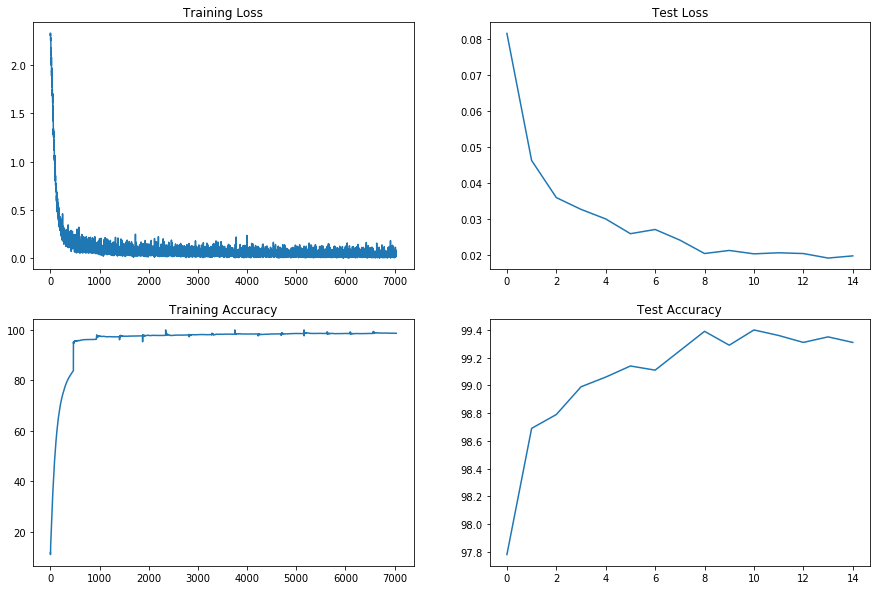

In [34]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")